# Laboratório 8
Material desenvolvido por Henrique Margotte e Aurora Pozo para a disciplina de Aprendizado de Máquina, para o curso de Informática Biomédica da UFPR, semestre 2025/2. Códigos baseados em exemplos da biblioteca scikit-learn e nos notebooks Python do livro "Inteligência Artificial: Uma Abordagem de Aprendizado de Máquina", 2ª edição.

# Exemplo 1: Ensembles
Durante os laboratórios, vimos diversos modelos de Aprendizado de Máquina, desde os mais tradicionais até as cada vez mais complexas redes neurais. E vimos que cada modelo tem suas vantagens e desvantagens, conseguindo resultados melhores ou piores para cada tipo de problema, variando até mesmo entre versões diferentes de um mesmo modelo, ao ajustarmos seus hiperparâmetros. Também vimos como realizar comparações e experimentos para definir qual é o melhor para determinada tarefa.

Mas, e se não quisermos usar apenas um modelo? E se usarmos mais de uma variação de um mesmo modelo? Se combinarmos diferentes modelos de Aprendizado de Máquina, poderíamos obter melhores resultados que apenas um? Essas são as ideias trabalhadas pelo conceito de `Ensemble`.

Ensemble consiste na combinação de vários modelos para resolver um mesmo problema. Em uma tarefa de classificação, seria o uso de diferentes classificadores, ou variações de um mesmo classificador, que combinados geram a classe para o exemplo. Existem várias estratégias para realizar isso, veremos algumas a seguir. 

## Exemplo 1.1: Bagging
O *Bootstrap Aggregating*, ou *Bagging*, é uma técnica de Ensemble de classificadores homogêneos, ou seja, a combinação de variações de um mesmo classificador. No Bagging, o que é variado é a base de dados em que cada classificador é treinado. O conjunto de treinamento é dividido em *n* amostras do mesmo tamanho do conjunto original, removendo alguns exemplos e repetindo outros, com cada classificador sendo treinado com uma dessas amostras. Após o treinamento, a classificação pode ser feita através de um esquema de voto, em que cada classificador indica uma classe e a mais indicada é atribuída ao exemplo.

Esse tipo de método é mais eficaz em algoritmos considerados instáveis, que podem sofrer grandes alterações com poucas mudanças nos dados, como a Árvore de Decisão, que diferencia seu resultado apartir dos atributos escolhidos para a decisão. Utilizar Bagging ajuda a diminuir a variabilidade dos resultados. Veremos a seguir um exemplo de uso de Bagging com Árvore de Decisão na base de dados `digits`.

In [8]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Carrega dataset ---
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Modelo base ---
base_tree = DecisionTreeClassifier(max_depth=None, random_state=42)

# --- Bagging ensemble ---
bagging = BaggingClassifier(
    estimator=base_tree,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42
)

# --- Treino ---
bagging.fit(X_train, y_train)

# --- Avaliação ---
y_pred = bagging.predict(X_test)
print("Acurácia Árvore Única:", accuracy_score(y_test, base_tree.fit(X_train, y_train).predict(X_test)))
print("Acurácia Bagging Ensemble:", accuracy_score(y_test, y_pred))


Acurácia Árvore Única: 0.8416666666666667
Acurácia Bagging Ensemble: 0.9222222222222223


Apenas com esse exemplo, já podemos verificar que o uso de Ensemble contribui para a melhora do modelo, quando comparado com apenas um exemplo.

Podemos também verificar como cada classificador, ou estimador, realiza a votação.

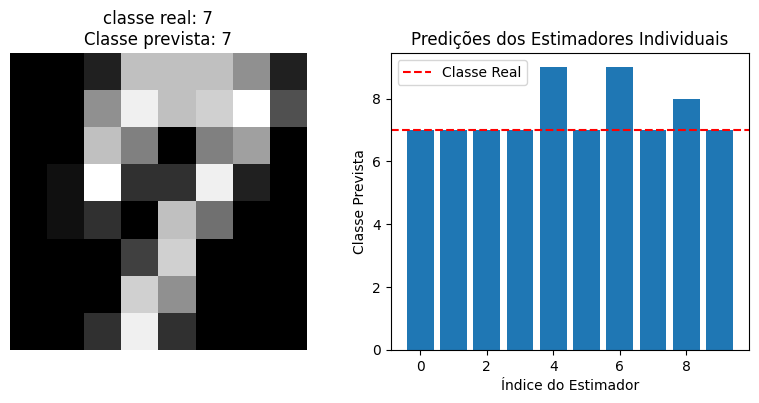

In [ ]:
# Define um exemplo para visualização
idx = 3
sample = X_test[idx]
true_label = y_test[idx]

# Obtem as previsões de cada árvore individual
individual_preds = [est.predict([sample])[0] for est in bagging.estimators_]
final_pred = bagging.predict([sample])[0]

# --- Plot ---
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample.reshape(8, 8), cmap='gray')
plt.title(f"classe real: {true_label}\nClasse prevista: {final_pred}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(range(len(individual_preds)), individual_preds)
plt.axhline(true_label, color='red', linestyle='--', label='Classe Real')
plt.xlabel("Índice do Estimador")
plt.ylabel("Classe Prevista")
plt.title("Predições dos Estimadores Individuais")
plt.legend()
plt.tight_layout()
plt.show()

### Random Forest
Um dos modelos mais eficientes de Aprendizado de Máquina trata-se do algoritmo de *Random Forest* (Floresta Aleatória em uma tradução direta para o português). Esse modelo na verdade é um Ensemble de Árvores de Decisão com Bagging, mas com uma alteração adicional, a cada nó das árvores, são considerados apenas alguns atributos para definir a decisão, selecionados de forma aleatória, gerando ainda mais variações nas árvores geradas. Veremos um exemplo de aplicação no scikit-learn. Os hiperparâmetros principais desse modelo é o número de árvores da floresta e a quantidade de atributos para ser utilizado em cada nó (definiremos como o padrão da biblioteca, sendo a raiz quadrada da quantidade de atributos para problemas de classificação e um terço dos atributos para regressão).

In [11]:
# Random Forest para digits
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_features='sqrt', max_depth=None, random_state=42)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)

print("Acurácia Random Forest:", accuracy_score(y_test, y_rf_pred))

Acurácia Random Forest: 0.9583333333333334


## Exemplo 1.2: Boosting
O *Boosting* é uma técnica de Ensemble que se baseia em outra ideia, a de usar vários classificadores "fracos" (com taxa de acerto pouco melhor que um chute aleatório) para gerar um "forte". Nele, os classificadores são treinados em sequência, aumentando os pesos dos exemplos que o classificador anterior errou, de forma que cada classificador novo irá tentar acertar onde o anterior falhou. Após o treinamneto, a classe atribuída é dada pela votação ponderada dos classificadores, com os que tiveram maior taxa de acerto tendo maior poder de voto.

Um dos métodos de Boosting mais simples é o `AdaBoost` (de *Adaptive Boosting*), apresentaremos um exemplo usando `stumps`, ou tocos, Árvores de Decisão de apenas um nó, ou seja, que dividem o conjunto de dados em dois grupos a partir de um atributo. Os hiperparâmetros que podemos variar é a quantidade de estimadores e a taxa de aprendizado, similar a uma rede neural.

In [14]:
from sklearn.ensemble import AdaBoostClassifier

# Classificador fraco (stump = árvore de profundidade 1)
stump = DecisionTreeClassifier(max_depth=1)

# AdaBoost ensemble
ada = AdaBoostClassifier(estimator=stump, n_estimators=100, learning_rate=1.0, random_state=42)
ada.fit(X_train, y_train)

print("Acurácia AdaBoost:", accuracy_score(y_test, ada.predict(X_test)))

Acurácia AdaBoost: 0.8277777777777777


## Exemplo 1.3: Stacking
Outro exemplo é o *Stacking*, ou Generalização em Pilha. Essa técnica de Ensemble já utiliza diferentes modelos para classificação, os organizando em camadas. Um formato usual é definir duas camadas, em que a primeira camada utiliza vários classificadores e a segunda, composta de um único modelo normalmente linear ou de regressão logística, também chamado de "meta-modelo", decide qual dos classificadores será utilizado para o exemplo.

Podemos montar um Ensemble utilizando as técnicas que já vimos com o `StackingClassifier` do scikit-learn. Os hiperparâmetros definidos são os modelos base, o modelo final/meta-modelo (por padrão, `LogisticRegression`) e o `k` da validação cruzada aplicada para treinar o modelo final (por padrão, 5).

In [17]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Define os modelos base
estimators = [
    ('dt', DecisionTreeClassifier()),
    ('gnb', GaussianNB()),
    ('knn', KNeighborsClassifier())
]

# Stacking ensemble
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

stacking.fit(X_train, y_train)
y_stacking_pred = stacking.predict(X_test)

print("Acurácia Stacking:", accuracy_score(y_test, y_stacking_pred))

Acurácia Stacking: 0.9888888888888889


### Visualizando como o Stacking tomou a decisão
Também podemos ver como foi o processo de classificação do Stacking. O quanto cada modelo final é considerado para o resultado e como os modelos classificaram um mesmo exemplo.

In [45]:
# Define um exemplo para visualização
idx = 7
sample = X_test[idx].reshape(1, -1)
true_label = y_test[idx]

# Probabilidade dos modelos base
probas = np.array([clf.predict_proba(sample).ravel() for name, clf in stacking.named_estimators_.items()])

# Obter a previsão final do stacking
final_pred = stacking.predict(sample)[0]

print(f"Classe real: {true_label}")
print(f"Previsão final do Stacking: {final_pred}")


Classe real: 2
Previsão final do Stacking: 2


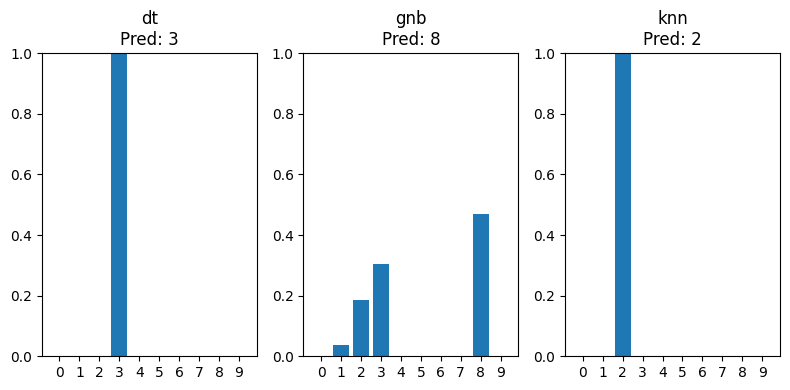

In [ ]:
# Como cada modelo classificou o exemplo
classes = np.arange(10)
plt.figure(figsize=(8, 4))

for i, (name, probs) in enumerate(zip(stacking.named_estimators_.keys(), probas)):
    plt.subplot(1, len(probas), i+1)
    plt.bar(classes, probs)
    plt.title(f"{name}\nPred: {classes[np.argmax(probs)]}")
    plt.xticks(classes)
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

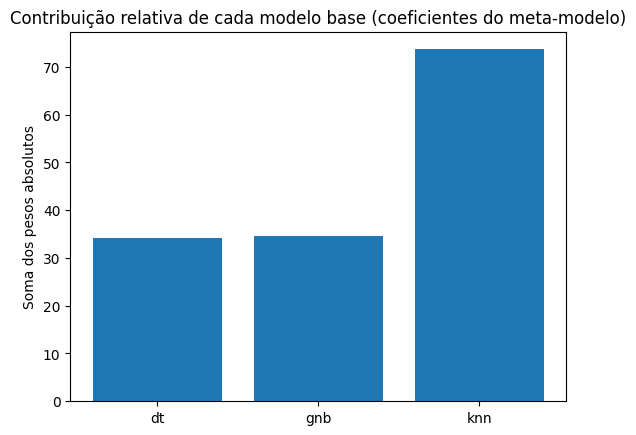

In [46]:
# Quanto cada modelo contribui para a decisão final
meta_model = stacking.final_estimator_
coef = meta_model.coef_

n_classes = len(np.unique(y))
n_base = len(estimators)

# Soma dos pesos de contribuição absoluta para cada modelo base em todas as classes
importance = np.abs(coef).sum(axis=0).reshape(n_base, n_classes).sum(axis=1)

plt.bar([name for name, _ in estimators], importance)
plt.title("Contribuição relativa de cada modelo base (coeficientes do meta-modelo)")
plt.ylabel("Soma dos pesos absolutos")
plt.show()


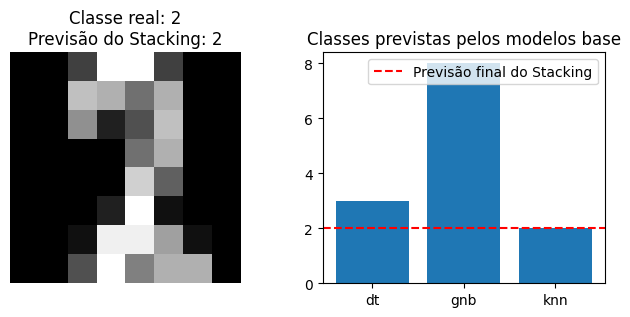

In [47]:
# Visualização final do exemplo
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(X_test[idx].reshape(8, 8), cmap='gray')
plt.title(f"Classe real: {true_label}\nPrevisão do Stacking: {final_pred}")
plt.axis('off')

plt.subplot(1, 2, 2)
base_preds = [clf.predict(sample)[0] for name, clf in stacking.named_estimators_.items()]
plt.bar(stacking.named_estimators_.keys(), base_preds)
plt.axhline(final_pred, color='red', linestyle='--', label='Previsão final do Stacking')
plt.legend()
plt.title("Classes previstas pelos modelos base")
plt.show()


# Exercício!

SUA VEZ!

